In [1]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
from matplotlib import pyplot as plt

In [2]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 2
ALT_MIN, ALT_MAX = 0.5, 64.5
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000

In [3]:
def process_dataarray(da_o3):
    da_transposed = da_o3.transpose('time', 'altitude')
    
    n_time = da_transposed.sizes['time']
    n_alt = da_transposed.sizes['altitude']
    
    time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
    alt_chunks = min(32, n_alt)
    
    if isinstance(da_transposed.data, da.Array):
        da_transposed = da_transposed.chunk({'time': time_chunks, 'altitude': alt_chunks})
    else:
        da_transposed.data = da.from_array(da_transposed.data, 
                                          chunks=(time_chunks, alt_chunks))
    
    return da_transposed

def compute_diffs(o3L, o3S):
    """Vectorized relative and absolute difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [4]:
import OSIRIS.OSIRIS_helper as OSIRIS
import ACEFTS.ACEFTS_helper as ACE

In [5]:
daL = OSIRIS.get_vmr()
daS = ACE.get_vmr()

In [6]:
daL = daL.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})
daS = daS.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})

daL = process_dataarray(daL)
daS = process_dataarray(daS)

assert np.array_equal(daL.altitude.values, ALT_GRID), "OSIRIS alt mismatch!"
assert np.array_equal(daS.altitude.values, ALT_GRID), "ACE-FTS alt mismatch!"

In [7]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)


In [8]:
o3L_arr = daL.values.astype(np.float32)
o3S_arr = daS.values.astype(np.float32)
tL = daL.time.values.astype('datetime64[ns]')
tS = daS.time.values.astype('datetime64[ns]')
latL = daL.latitude.values
lonL = daL.longitude.values
latS = daS.latitude.values
lonS = daS.longitude.values

tS_min = tS.min() - TIME_TOL
tS_max = tS.max() + TIME_TOL
time_mask = (tL >= tS_min) & (tL <= tS_max)
tL_filtered = tL[time_mask]
o3L_arr_filtered = o3L_arr[time_mask]
latL_filtered = latL[time_mask]
lonL_filtered = lonL[time_mask]

client.close()
cluster.close()
del o3L_arr, latL, lonL
gc.collect()

c:\Users\salla\anaconda3\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 65.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


60817

In [9]:
import os

# Define which extensions you consider “image files”
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.svg'}

def count_images(root_folder):
    count = 0
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for fname in filenames:
            ext = os.path.splitext(fname)[1].lower()
            if ext in IMAGE_EXTENSIONS:
                count += 1
    return count

if __name__ == '__main__':
    folder = r'C:\Users\salla\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\O3_ANALYSIS'
    total_images = count_images(folder)
    print(f'Total image files (recursively) in "{folder}": {total_images}')


Total image files (recursively) in "C:\Users\salla\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\O3_ANALYSIS": 119


In [10]:
tL_ns = tL_filtered.astype(np.int64)
tS_ns = tS.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

n_alt = len(ALT_GRID)
MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
o3S_coincidences = []
o3L_coincidences = []
measurement_times = []

time_bins = np.arange(tL_ns.min(), tL_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tL_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tS_ns, latS, lonS)):
    if s_idx % 10000 == 0:
        print(f"Processing ACE-FTS point {s_idx}/{len(tS)}...")
    
    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tL_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latL_filtered[time_valid_indices]
    candidate_lons = lonL_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]
    
    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3L_coincidences.append(o3L_arr_filtered[best_L_idx])
        o3S_coincidences.append(o3S_arr[s_idx])
        processed_pairs += 1
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at ACE point {s_idx}...")

        measurement_times.append(tL_ns[best_L_idx])

o3S_coincidences = np.vstack(o3S_coincidences)
o3L_coincidences = np.vstack(o3L_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing ACE-FTS point 0/132071...
Processing ACE-FTS point 10000/132071...
Found 1000 pairs at ACE point 14359...
Processing ACE-FTS point 20000/132071...
Found 2000 pairs at ACE point 23709...
Processing ACE-FTS point 30000/132071...
Found 3000 pairs at ACE point 30832...
Processing ACE-FTS point 40000/132071...
Found 4000 pairs at ACE point 42460...
Processing ACE-FTS point 50000/132071...
Found 5000 pairs at ACE point 57074...
Processing ACE-FTS point 60000/132071...
Processing ACE-FTS point 70000/132071...
Processing ACE-FTS point 80000/132071...
Found 6000 pairs at ACE point 89659...
Processing ACE-FTS point 90000/132071...
Processing ACE-FTS point 100000/132071...
Processing ACE-FTS point 110000/132071...
Processing ACE-FTS point 120000/132071...
Processing ACE-FTS point 130000/132071...
Total coincidences found: 6675


In [ ]:
import matplotlib as mpl
max_time = max(measurement_times)
min_time = min(measurement_times)
n_coincidences = len(measurement_times)
normalizer = plt.Normalize(vmin=min_time, vmax=max_time, clip=True)
cmap = plt.get_cmap('nipy_spectral', n_coincidences)
measurement_colors = cmap(np.linspace(0, 1, n_coincidences))
mappable = mpl.cm.ScalarMappable(norm=normalizer, cmap=cmap)


: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for coincidence_idx in range(n_coincidences):
    ace_values = o3S_coincidences[coincidence_idx, :] * 10**6
    
    osiris_values = o3L_coincidences[coincidence_idx, :] * 10**6
    
    axes[0].plot(
        ace_values,
        ALT_GRID,
        color=measurement_colors[coincidence_idx],
        alpha=0.7
    )
    
    axes[1].plot(
        osiris_values,
        ALT_GRID,
        color=measurement_colors[coincidence_idx],
        alpha=0.7
    )

axes[0].set_xlabel("O$_3$ VMR (ppmv)")
axes[1].set_xlabel("O$_3$ VMR (ppmv)")
axes[0].set_ylabel("Altitude (km)")

xmin, xmax = axes[0].get_xlim()

axes[0].set_xlim(xmin, 14)
axes[1].set_xlim(xmin, 14)

cbar = fig.colorbar(
    mappable,
    ax=axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.02
    # ticks = tick_labels
)

cbar.ax.set_yticklabels(cbar.get_ticks().astype('datetime64[ns]').astype('datetime64[D]').astype(str))

plt.suptitle("ACE-FTS (left) and OSIRIS (right) Individual Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Global, All Time)")

axes[0].text(0.810, 0.0325, f"N = {len(o3L_coincidences)}", fontsize=15, transform=axes[0].transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
axes[1].text(0.810, 0.035, f"N = {len(o3L_coincidences)}", fontsize=15, transform=axes[1].transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_22632\3969660699.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.get_ticks().astype('datetime64[ns]').astype('datetime64[D]').astype(str))


In [ ]:
rel, abs = compute_diffs(o3L_coincidences, o3S_coincidences)

C:\Users\salla\AppData\Local\Temp\ipykernel_16924\567426079.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.get_ticks().astype('datetime64[ns]').astype('datetime64[D]').astype(str))


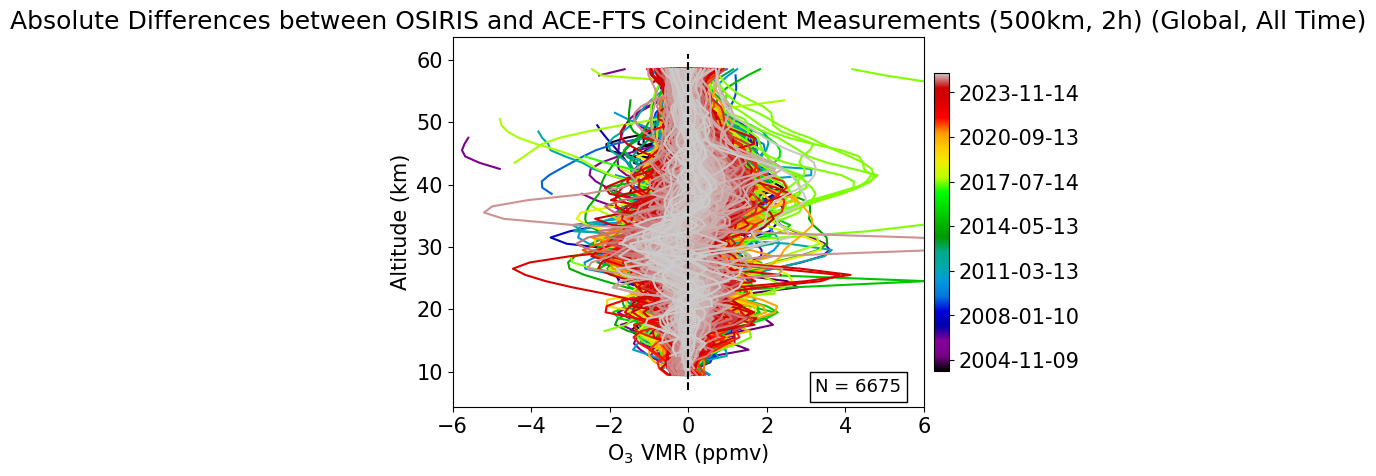

In [ ]:
for i in range(n_coincidences):
    plt.plot(abs[i,:] * 10**6, ALT_GRID, color = measurement_colors[i])

plt.xlim(-6,6)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between OSIRIS and ACE-FTS Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Global, All Time)")

fig = plt.gcf()
axes = plt.gca()

cbar = fig.colorbar(
    mappable,
    ax=axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.02
)

cbar.ax.set_yticklabels(cbar.get_ticks().astype('datetime64[ns]').astype('datetime64[D]').astype(str))

axes.text(0.77, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [ ]:
rel_diffs = np.nanmean(rel, axis = 0)
rel_std = np.nanstd(rel, axis = 0)
rel_err = rel_std / (rel.shape[0] ** 0.5)

abs_diffs = np.nanmean(abs, axis = 0)
abs_std = np.nanstd(abs, axis = 0)
abs_err = np.nanstd(abs, axis = 0) / (abs.shape[0] ** 0.5)

C:\Users\salla\AppData\Local\Temp\ipykernel_16924\1016612721.py:1: RuntimeWarning: Mean of empty slice
  rel_diffs = np.nanmean(rel, axis = 0)
c:\Users\salla\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\salla\AppData\Local\Temp\ipykernel_16924\1016612721.py:5: RuntimeWarning: Mean of empty slice
  abs_diffs = np.nanmean(abs, axis = 0)


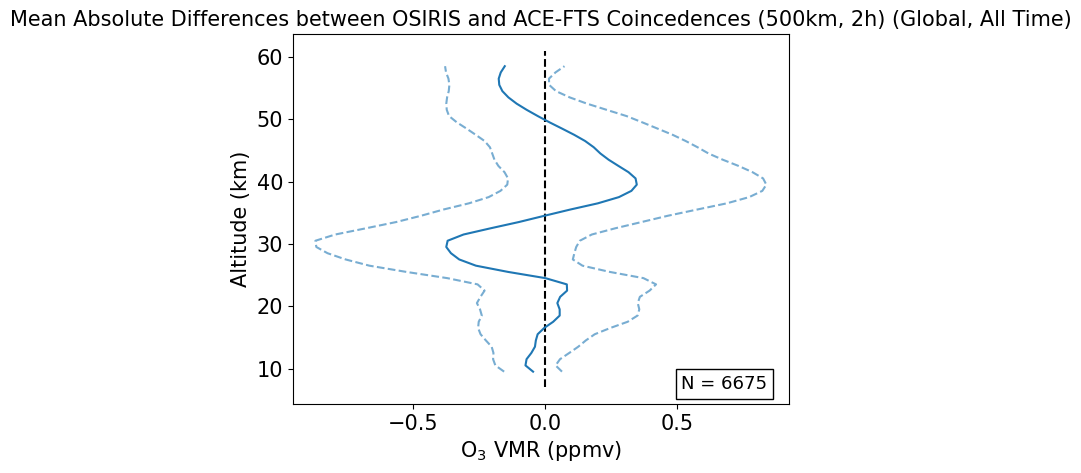

In [ ]:
plt.errorbar(abs_diffs * 10**6, ALT_GRID)
plt.errorbar((abs_diffs - abs_std) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.errorbar((abs_diffs + abs_std) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean Absolute Differences between OSIRIS and ACE-FTS Coincedences" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Global, All Time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

axes.text(0.783, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

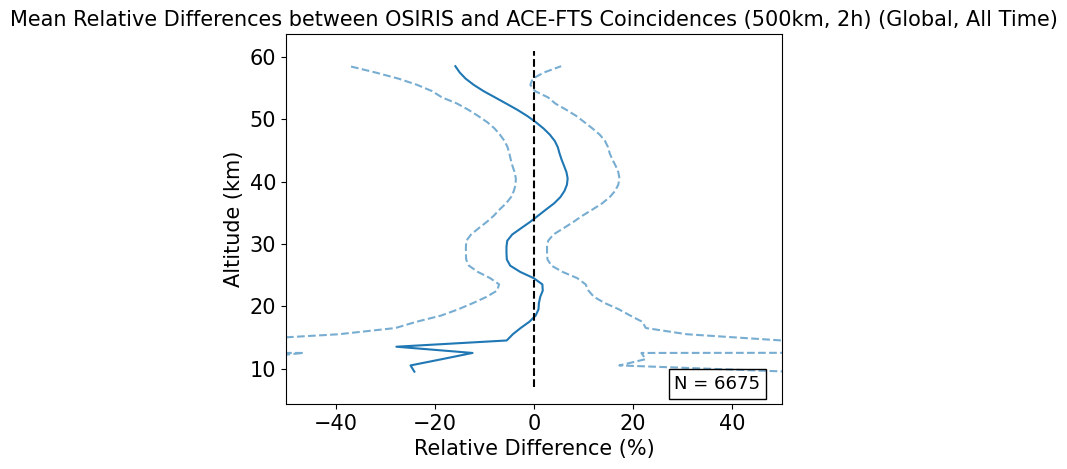

In [ ]:
plt.plot(rel_diffs, ALT_GRID)
plt.plot((rel_diffs - rel_std), ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot((rel_diffs + rel_std), ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlim(-50,50)
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Mean Relative Differences between OSIRIS and ACE-FTS Coincidences" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Global, All Time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

axes.text(0.783, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_16924\3107456838.py:3: RuntimeWarning: Mean of empty slice
  mean_L = np.nanmean(o3L_coincidences, axis = 0)
C:\Users\salla\AppData\Local\Temp\ipykernel_16924\3107456838.py:4: RuntimeWarning: Mean of empty slice
  mean_S = np.nanmean(o3S_coincidences, axis = 0)


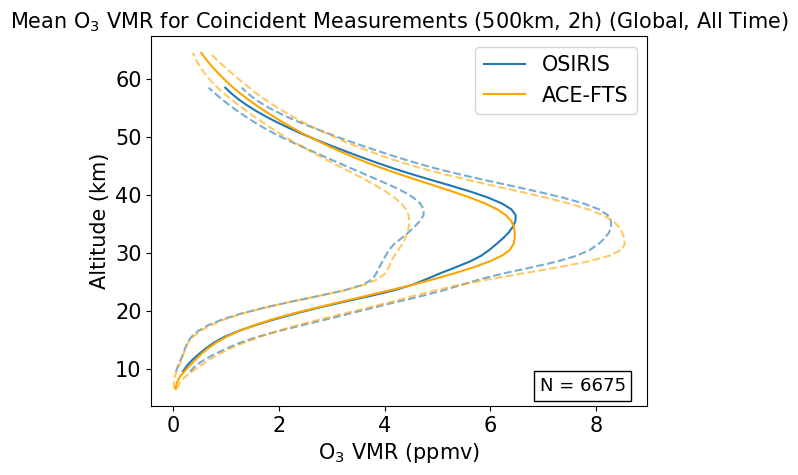

In [ ]:
std_L = np.nanstd(o3L_coincidences, axis = 0)
std_S = np.nanstd(o3S_coincidences, axis = 0)
mean_L = np.nanmean(o3L_coincidences, axis = 0)
mean_S = np.nanmean(o3S_coincidences, axis = 0)


plt.plot(mean_L * 10**6, ALT_GRID, label = "OSIRIS")
plt.plot((mean_L - std_L) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot((mean_L + std_L) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)

plt.plot(mean_S * 10**6, ALT_GRID, label = "ACE-FTS", color = "orange")
plt.plot((mean_S + std_S) * 10**6, ALT_GRID, color = "orange", linestyle = "dashed",  alpha = 0.6)
plt.plot((mean_S - std_S) * 10**6, ALT_GRID, color = "orange", linestyle = "dashed",  alpha = 0.6)

plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean O$_3$ VMR for Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Global, All Time)", fontdict = {'fontsize': 15})
plt.legend()

fig = plt.gcf()
axes = plt.gca()

axes.text(0.783, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(OSIRIS and ACE-FTS)", bbox_inches="tight")

In [ ]:
o3L_std = np.nanstd(o3L_coincidences, axis = 0)[None, :]
o3S_std = np.nanstd(o3S_coincidences, axis = 0)[None, :]
o3L_mean = np.nanmean(o3L_coincidences, axis = 0)[None, :]
o3S_mean = np.nanmean(o3S_coincidences, axis = 0)[None, :]

C:\Users\salla\AppData\Local\Temp\ipykernel_16924\2217330616.py:3: RuntimeWarning: Mean of empty slice
  o3L_mean = np.nanmean(o3L_coincidences, axis = 0)[None, :]
C:\Users\salla\AppData\Local\Temp\ipykernel_16924\2217330616.py:4: RuntimeWarning: Mean of empty slice
  o3S_mean = np.nanmean(o3S_coincidences, axis = 0)[None, :]


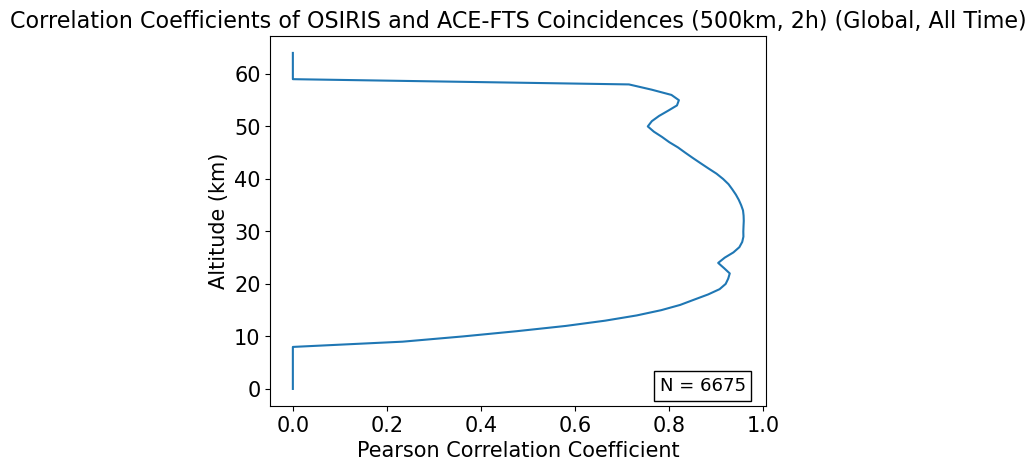

In [ ]:
summing = np.nansum(((o3L_coincidences - o3L_mean) / o3L_std) * ((o3S_coincidences - o3S_mean) / o3S_std), axis = 0) 

plt.plot(summing / (o3L_coincidences.shape[0] - 1), np.arange(len(summing)))
plt.ylabel("Altitude (km)")
plt.xlabel("Pearson Correlation Coefficient")
plt.title("Correlation Coefficients of OSIRIS and ACE-FTS Coincidences" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (Global, All Time)", fontdict = {"fontsize": 16})

fig = plt.gcf()
axes = plt.gca()

axes.text(0.785, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [ ]:
# fig = pcm_monthly.fig
# title = fig._suptitle.get_text()
# fig.savefig(title, bbox_inches="tight")

# fig = plt.gcf()
# axes = plt.gca()

# title = axes.get_title()
# fig.savefig(title, bbox_inches="tight")